# CH5. 분류(Classification)
 - 여러 카테고리 중 어디에 속할지 예측하는 것이 목표
 
 - 모델에 단순히 이진 분류 결과를 할당하는 대신, 대부분의 알고리즘은 관심 클래스에 속할 확률 점수(경향, propensity)을 반환
 
 
 - 일반적인 접근 방식:
 1. 어떤 레코드가 속할 거라고 생각되는 관심 클래스에 대한 컷오프 확률 정의
 2. 레코드가 관심 클래스에 속할 확률을 (모든 모델과 함께) 추정
 3. 그 확률이 컷오프 확률 이상이면 관심 클래스에 해당 레코드 할당

In [7]:
pip install --upgrade numpy

Note: you may need to restart the kernel to use updated packages.


In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.naive_bayes import MultinomialNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression #, LogisticRegressionCV
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
from sklearn.metrics import roc_curve, accuracy_score, roc_auc_score

import statsmodels.api as sm

## 5.1 나이브베이즈(naive Bayes)
 - <b>나이브 베이즈</b> 알고리즘: 주어진 결과에 대해 예측변숫값을 관찰할 확률을 사용하여, 예측변수가 주어졌을 때 결과 $Y=i$를 관찰할 확률, 즉 정말 관심 있는 것을 추정한다.
 
 ===============================================================================================================
 ###### 용어정리
  - 조건부확률(conditional probability): 어떤 사건($Y=i$)이 주어졌을 때, 해당 사건($X=i$)을 관찰할 확률 $P(X_i|Y_i)$
  - 사후확률(posterior probability): 예츠 정보를 통합한 후 결과의 확률(이와 달리, <b>사전확률</b>에서는 예측변수에 대한 정보를 고려하지 않는다.)
  
 ===============================================================================================================
 
 - 베이즈 분류
 1. 예측변수 프로파일이 동일한(즉, 예측변수와 값이 동일한) 모든 레코드 찾기
 2. 해당 레코드들이 가장 많이 속한 (즉, 가능성이 높은) 클래스 정하기
 3. 새 레코드에 해당 클래스 지정
 
###### NOTE_ 
표준 나이브 베이즈 알고리즘에서 예측변수는 범주형 변수(요인변수)여야 함. 연속형 변수를 다루는 두 방법은 5.1.3에서 설명

### 5.1.1 나이브하지 않은 베이즈 분류는 왜 현실성이 없을까?
 - 데이터가 커질수록 프로파일이 동일한 레코드가 희박함
 
*naive: (경험, 지식 등의 부족으로)순진한, 순진해 빠진, 순진무구한*

### 5.1.2 나이브한 해법
- <b>나이브 베이즈 방법</b>
1. 이진 응답 $Y=i(i=0 또는 1)$에 대해, 각 예측변수에 대한 조건부확률 $P(X_j|Y=i)$를 구한다. 이것은 $Y=i$가 주어질 때, 예측변수의 값이 나올 확률이다. 이 확률은 훈련 데이터(training set)에서 $Y=i$인 레코드들 중 $X_j$값의 비율로 구할 수 있다.
2. 각 확률값을 곱한 다음, $Y=i$에 속한 레코드들의 비율을 곱한다.
3. 모든 클래스에 대해 1~2단계를 반복한다.
4. 2단계에서 모든 클래스에 대해 구한 확률값을 모두 더한 값으로 클래스 $i$의 확률을 나누면 결과 $i$의 확률을 구할 수 있다.
5. 이 예측변수에 대해 가장 높은 확률을 갖는 클래스를 해당 레코드에 할당한다.

<br>

- 나이브 베이즈 분류기는 편향된 추정 결과를 예측하는 것으로 잘 알려져 있다.
- 하지만 $Y=1$인 확률에 따라 레코드들에 순위를 매기는 것이 목적이므로 확률의 비편향된 추정치를 굳이 구할 필요가 없다면, 나이브 베이즈도 나름 우수한 결과를 보인다.

In [2]:
from sklearn.naive_bayes import MultinomialNB

In [3]:
loan_data = pd.read_csv('C:/data/stats_for_ds/loan_data.csv') ;loan_data

,Unnamed: 0,status,loan_amnt,term,annual_inc,dti,payment_inc_ratio,revol_bal,revol_util,purpose,...,delinq_2yrs_zero,pub_rec_zero,open_acc,grade,outcome,emp_length,purpose_,home_,emp_len_,borrower_score
0,1,Charged Off,2500,60 months,30000,1.00,2.39320,1687,9.4,car,...,1,1,3,4.8,default,1,major_purchase,RENT,> 1 Year,0.65
1,2,Charged Off,5600,60 months,40000,5.55,4.57170,5210,32.6,small_business,...,1,1,11,1.4,default,5,small_business,OWN,> 1 Year,0.80
2,3,Charged Off,5375,60 months,15000,18.08,9.71600,9279,36.5,other,...,1,1,2,6.0,default,1,other,RENT,> 1 Year,0.60
3,4,Charged Off,9000,36 months,30000,10.08,12.21520,10452,91.7,debt_consolidation,...,1,1,4,4.2,default,1,debt_consolidation,RENT,> 1 Year,0.50
4,5,Charged Off,10000,36 months,100000,7.06,3.90888,11997,55.5,other,...,1,1,14,5.4,default,4,other,RENT,> 1 Year,0.55
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45337,45338,Fully Paid,8000,36 months,72000,18.97,4.57850,9725,58.2,credit_card,...,1,0,9,4.2,paid off,8,credit_card,RENT,> 1 Year,0.35
45338,45339,Fully Paid,2000,36 months,25200,13.24,3.20333,4925,40.7,wedding,...,0,1,13,4.2,paid off,3,other,MORTGAGE,> 1 Year,0.50
45339,45340,Fully Paid,4375,36 months,20000,7.95,9.98460,6574,73.0,debt_consolidation,...,1,1,8,2.4,paid off,1,debt_consolidation,MORTGAGE,> 1 Year,0.55
45340,45341,Fully Paid,8000,36 months,48000,26.91,6.45250,10303,32.4,debt_consolidation,...,1,1,10,5.2,paid off,1,debt_consolidation,MORTGAGE,> 1 Year,0.65


In [4]:
# convert to categorical
loan_data.outcome = loan_data.outcome.astype('category')
loan_data.outcome.cat.reorder_categories(['paid off', 'default'])
loan_data.purpose_ = loan_data.purpose_.astype('category')
loan_data.home_ = loan_data.home_.astype('category')
loan_data.emp_len_ = loan_data.emp_len_.astype('category')

predictors = ['purpose_', 'home_', 'emp_len_']
outcome = 'outcome'
X = pd.get_dummies(loan_data[predictors], prefix='', prefix_sep='')
y = loan_data[outcome]

In [5]:
naive_model = MultinomialNB(alpha=0.01, fit_prior=True)
naive_model = MultinomialNB(alpha=0, fit_prior=False)
naive_model.fit(X, y)

new_loan = X.loc[146:146, :]
print('predicted class: ', naive_model.predict(new_loan)[0])

predicted class:  default


C:\Users\minjw\anaconda3\lib\site-packages\sklearn\naive_bayes.py:508: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn('alpha too small will result in numeric errors, '


In [6]:
probabilities = pd.DataFrame(naive_model.predict_proba(new_loan),
                             columns=naive_model.classes_)
print('predicted probabilities',)
print(probabilities)

predicted probabilities
    default  paid off
0  0.653699  0.346301


### 5.1.3 수치형 예측변수
<b>수치형 변수에 나이브 베이즈 방법을 적용하기 위해 다음 두 가지 접근법 중 하나를 따라야 한다.</b>
1. 수치형 예측변수를 비닝(binning)하여 범주형으로 변환한 뒤, 알고리즘 적용
2. 조건부 확률 $P(X_j|Y=i)$를 추정하기 위해 정규분포 같은 확률모형 사용

###### CAUTION_
훈련 데이터에 예측변수의 특정 카테고리에 해당하는 데이터가 없을 때에는, 다른 기법들처럼 이 변수를 무시하고 다른 변수들의 정보를 사용하는 대신, 나이브 베이즈 알고리즘은 새 데이터 결과에 대한 <b>확률을 0으로</b> 할당한다. 나이브 베이즈를 구현한 대부분의 경우에는 이를 방지하기 위해 평활화 인수(라플라스 평활화)를 사용한다.

###### 주요개념
- 나이브 베이즈는 예측변수와 결과변수 모두 범주형(요인)이어야 한다.
- '각 출력 카테고리 안에서, 어떤 예측변수의 카테고리가 가장 가능성이 높은가?'가 답하고자 하는 질문이다.
- 그리고 이 정보는 주어진 예측변수 값에 대해, 결과 카테고리의 확률을 추정하는 것으로 바뀐다.

## 5.2 판별분석(discriminant analysis)

==========================================================================================================
###### 용어정리
- 공분산(covariance): 하나의 변수가 다른 변수와 함께 변화하는 정도(유사한 크기와 방향)를 측정하는 지표
- 판별함수(discriminant function): 예측변수에 적용했을 때, 클래스 구분을 최대화하는 함수
- 판별 가중치(discriminant weight): 판별함수를 적용하여 얻은 점수를 말하며, 어떤 클래스에 속할 확률을 추정하는 데 사용된다.

==========================================================================================================

- 가장 일반적으로 사용되는 것: <b>선형판별분석</b>(LDA, linear discriminant analysis)
- 트리 모델이나 로지스틱 회귀와 같은 더 정교한 기법이 출현한 이후로는 LDA를 그렇게 많이 사용하지 않는다.
- But, 여전히 일부 응용 분야에서 사용되고 있으며, 주성분분석과 같이 아직도 많이 사용되는 다른 방법들과도 연결된다.


### 5.2.1 공분산행렬
- 변수 $x$와 $z$사이의 공분산 $S_{x,z}$:
$$ S_{x,z} = \frac { \sum_{i=1}^n{(x_i-\bar{x})(z_i-\bar{z})} } {n-1} $$

###### NOTE_
변수를 $z$ 점수로 변환할 때 표준편차를 사용했던 것을 떠올려보자. 이를 확장하여 다변량분석에서 표준화 처리를 하기 위해 공분산행렬을 사용하는 것이다. 이를 마할라노비스 거리라고 부르며 LDA함수와 관련이 있다.

### 5.2.2 피셔의 선형판별
ex. 두 개의 연속형 변수 $(x, z)$를 사용하여 이진 결과변수 $y$를 예측하려는 분류문제
- 선형판별분석(LDA)는 '내부' 제곱합 $SS_{내부}$(그룹 안의 변동을 측정)에 대한 '사이' 제곱합 $SS_{사이}$(두 그룹 사이의 편차를 측정)의 비율을 최대화 하는 것을 목표로 함
- 즉, $\frac {SS_{사이}} {SS_{내부}}$ (제곱합 비율)을 최대화 하는 선형결합 $w_xx+w_zz$을 찾는다.

### 5.2.3 간단한 예

In [7]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

loan3000 = pd.read_csv('C:/data/stats_for_ds/loan3000.csv') ;loan3000

,Unnamed: 0,outcome,purpose_,dti,borrower_score,payment_inc_ratio
0,32109,paid off,debt_consolidation,21.23,0.40,5.11135
1,16982,default,credit_card,15.49,0.40,5.43165
2,25335,paid off,debt_consolidation,27.30,0.70,9.23003
3,34580,paid off,major_purchase,21.11,0.40,2.33482
4,14424,default,debt_consolidation,16.46,0.45,12.10320
...,...,...,...,...,...,...
2995,36589,paid off,debt_consolidation,13.30,0.50,18.36620
2996,43889,paid off,other,6.09,0.60,1.80421
2997,7219,default,debt_consolidation,16.13,0.20,15.42180
2998,8987,default,debt_consolidation,18.39,0.45,8.92335


In [8]:
loan3000.outcome = loan3000.outcome.astype('category')

predictors = ['borrower_score', 'payment_inc_ratio']
outcome = 'outcome'

X = loan3000[predictors]
y = loan3000[outcome]

loan_lda = LinearDiscriminantAnalysis()
loan_lda.fit(X, y)
print(pd.DataFrame(loan_lda.scalings_, index=X.columns))


                          0
borrower_score     7.175839
payment_inc_ratio -0.099676


In [9]:
pred = pd.DataFrame(loan_lda.predict_proba(loan3000[predictors]),
                    columns=loan_lda.classes_)
print(pred.head())

    default  paid off
0  0.553544  0.446456
1  0.558953  0.441047
2  0.272696  0.727304
3  0.506254  0.493746
4  0.609952  0.390048


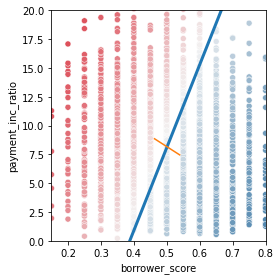

In [10]:
# [그림 5-1] 두 변수(채무자의 신용점수와 소득에 대한 지급 비율)를 사용한 연체에 대한 LDA 예측 결과
center = np.mean(loan_lda.means_, axis=0)
slope = - loan_lda.scalings_[0] / loan_lda.scalings_[1]
intercept = center[1] - center[0] * slope

# payment_inc_ratio for borrower_score of 0 and 20
x_0 = (0 - intercept) / slope
x_20 = (20 - intercept) / slope

lda_df = pd.concat([loan3000, pred['default']], axis=1)
lda_df.head()

fig, ax = plt.subplots(figsize=(4, 4))
g = sns.scatterplot(x='borrower_score', y='payment_inc_ratio',
                    hue='default', data=lda_df, 
                    palette=sns.diverging_palette(240, 10, n=9, as_cmap=True),
                    ax=ax, legend=False)

ax.set_ylim(0, 20)
ax.set_xlim(0.15, 0.8)
ax.plot((x_0, x_20), (0, 20), linewidth=3)
ax.plot(*loan_lda.means_.transpose())

plt.tight_layout()
plt.show()

###### 주요개념
- 판별분석은 예측변수나 결과변수가 범주형이든 연속형이든 상관없이 잘 동작한다.
- 공분산행렬을 사용하여 한 클래스와 다른 클래스에 속한 데이터들을 구분하는 <b>선형판별함수, linear discriminant function</b>를 계산할 수 있다.
- 이 함수를 통해 각 레코드가 어떤 클래스에 속할 가중치 혹은 점수(각 클래스당 점수)를 구한다.

## 5.3 로지스틱 회귀

==========================================================================================================
###### 용어정리
- 로짓(logit): (0~1)이 아니라 +-무한대의 범위에서 어떤 클래스에 속할 확률을 결정하는 함수 (유의어: 로그오즈)
- 오즈(odds): '실패'(0)에 대한 '성공'(1)의 비율
- 로그 오즈(log odds): 변환 모델(선형)의 응답변수. 이 값을 통해 확률을 구한다.

==========================================================================================================

### 5.3.1 로지스틱 반응 함수와 로짓
 - 로그 오즈 함수, 또는 로짓 함수는 0과 1 사이의 확률 $p$를 -무한대 ~ +무한대까지의 값으로 매핑해준다.
 
$$ odds(Y=1) = \frac {p} {1-p} $$

$$ p = \frac {odds} {1+odds} $$

$$ odds(Y=1) = e^{\beta_0+\beta_1x_1+\beta_2x_2 + ... + \beta_qx_q} $$

$$ log(odds(Y=1)) = \beta_0+\beta_1x_1+\beta_2x_2 + ... + \beta_qx_q $$

### 5.3.2 로지스틱 회귀와 GLM

In [11]:
from sklearn.linear_model import LogisticRegression #, LogisticRegressionCV

In [12]:
predictors = ['payment_inc_ratio', 'purpose_', 'home_', 'emp_len_', 
              'borrower_score']
outcome = 'outcome'
X = pd.get_dummies(loan_data[predictors], prefix='', prefix_sep='', 
                   drop_first=True)
y = loan_data[outcome] # .cat.categories

logit_reg = LogisticRegression(penalty='l2', C=1e42, solver='liblinear')
logit_reg.fit(X, y)


LogisticRegression(C=1e+42, solver='liblinear')

In [13]:
print('intercept ', logit_reg.intercept_[0])
print('classes', logit_reg.classes_)
pd.DataFrame({'coeff': logit_reg.coef_[0]}, 
             index=X.columns)

intercept  -1.6378907886011287
classes ['default' 'paid off']


,coeff
payment_inc_ratio,-0.079739
borrower_score,4.612183
debt_consolidation,-0.249414
home_improvement,-0.407734
major_purchase,-0.229710
medical,-0.510744
other,-0.620800
small_business,-1.214936
OWN,-0.048211
RENT,-0.157288


### 5.3.3 일반화선형모형
<b>일반화선형모형(GLM, generalized linear model)</b>은 다음 두 가지 주요 구성 요소로 특징지어진다.
 - 확률분포 또는 분포군(로지스틱 회귀의 경우 이항분포)
 - 응답을 예측변수에 매핑하는 연결(혹은 변형) 함수(로지스틱 회귀의 경우 로짓)

### 5.3.4 로지스틱 회귀의 예측값

$$ \hat{Y} = log(odds(Y=1)) $$

$$ \hat{p} = \frac {1} {1+e^{-\hat{Y}}} $$

In [14]:
pred = pd.DataFrame(logit_reg.predict_log_proba(X),
                    columns=logit_reg.classes_)
print(pred.describe())

            default      paid off
count  45342.000000  45342.000000
mean      -0.757872     -0.760434
std        0.378093      0.390456
min       -2.769376     -3.538593
25%       -0.985739     -0.977207
50%       -0.697406     -0.688907
75%       -0.472183     -0.467069
max       -0.029485     -0.064753


In [15]:
pred = pd.DataFrame(logit_reg.predict_proba(X),
                    columns=logit_reg.classes_)
print(pred.describe())

            default      paid off
count  45342.000000  45342.000000
mean       0.500000      0.500000
std        0.167354      0.167354
min        0.062701      0.029054
25%        0.373163      0.376361
50%        0.497875      0.502125
75%        0.623639      0.626837
max        0.970946      0.937299


### 5.3.5 계수와 오즈비 해석하기
- <b>오즈비</b>
$$ Odds Ratio = \frac {odds(Y=1|X=1)} {odds(Y=1|X=0)} $$

- 이진 요인변수 $X$가 있을 때, 위 식은 
- $X=1$일 때 $Y=1$인 경우의 오즈와 $X=0$일 때 $Y=1$인 경우의 오즈를 비교한 것
- 만약 오즈비가 2이면, 이것은 $X=1$일 때 $Y=1$인 경우의 오즈가 $X=0$일 때보다 두 배 더 높음을 의미

### 5.3.6 선형회귀와 로지스틱 회귀: 유사점과 차이점
- 공통점:
 - 예측변수와 응답변수를 선형 관계로 가정
 - 최적의 모델 탐색 과정도 유사
 - 스플라인 변환 방법은 로지스틱에도 적용 가능
 
- 차이점(로지스틱 회귀가 갖는 특징): 
 - 모델을 피팅하는 방식(최소제곱 사용 불가)
 - 모델에서 잔차의 특징과 분석
 
#### 모델피팅 
 - <b>최대우도추정(MLE, maximum likelihood estimation)</b> 활용 모델 피팅 
 - 최대우도추정이란, 우리가 보고 있는 데이터를 생성했을 가능성이 가장 큰 모델을 찾는  프로세스
 - 로지스틱 회귀식에서 응답변수는 0/1이 아니라, 응답이 1인 로그 오즈비의 추정치
 - MLE는 예상 로그 오즈비가 관찰된 결과를 가장 잘 설명하는 모델을 찾는다.

### 3.5.7 모델 평가하기


In [16]:
import statsmodels.api as sm

In [17]:
y_numbers = [1 if yi == 'default' else 0 for yi in y]
logit_reg_sm = sm.GLM(y_numbers, X.assign(const=1), 
                      family=sm.families.Binomial())
logit_result = logit_reg_sm.fit()
print(logit_result.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                45342
Model:                            GLM   Df Residuals:                    45330
Model Family:                Binomial   Df Model:                           11
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -28757.
Date:                Mon, 25 Oct 2021   Deviance:                       57515.
Time:                        00:56:13   Pearson chi2:                 4.54e+04
No. Iterations:                     4                                         
Covariance Type:            nonrobust                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
payment_inc_ratio      0.0797      0

In [18]:
import statsmodels.formula.api as smf
formula = ('outcome ~ bs(payment_inc_ratio, df=8) + purpose_ + ' +
           'home_ + emp_len_ + bs(borrower_score, df=3)')
model = smf.glm(formula=formula, data=loan_data, family=sm.families.Binomial())
results = model.fit()
print(results.summary())

                             Generalized Linear Model Regression Results                             
Dep. Variable:     ['outcome[default]', 'outcome[paid off]']   No. Observations:                45342
Model:                                                   GLM   Df Residuals:                    45321
Model Family:                                       Binomial   Df Model:                           20
Link Function:                                         logit   Scale:                          1.0000
Method:                                                 IRLS   Log-Likelihood:                -28731.
Date:                                       Mon, 25 Oct 2021   Deviance:                       57462.
Time:                                               00:56:14   Pearson chi2:                 4.54e+04
No. Iterations:                                            6                                         
Covariance Type:                                   nonrobust                      

#### 잔차분석

In [19]:
from statsmodels.genmod.generalized_linear_model import GLMResults
def partialResidualPlot(model, df, outcome, feature, fig, ax):
    y_actual = [0 if s == 'default' else 1 for s in df[outcome]]
    y_pred = model.predict(df)
    org_params = model.params.copy()
    zero_params = model.params.copy()
    # set model parametes of other features to 0
    for i, name in enumerate(zero_params.index):
        if feature in name:
            continue
        zero_params[i] = 0.0
    model.initialize(model.model, zero_params)
    feature_prediction = model.predict(df)
    ypartial = -np.log(1/feature_prediction - 1)
    ypartial = ypartial - np.mean(ypartial)
    model.initialize(model.model, org_params)
    results = pd.DataFrame({
        'feature': df[feature],
        'residual': -2 * (y_actual - y_pred),
        'ypartial': ypartial/ 2,
    })
    results = results.sort_values(by=['feature'])

    ax.scatter(results.feature, results.residual, marker=".", s=72./fig.dpi)
    ax.plot(results.feature, results.ypartial, color='black')
    ax.set_xlabel(feature)
    ax.set_ylabel(f'Residual + {feature} contribution')
    return ax

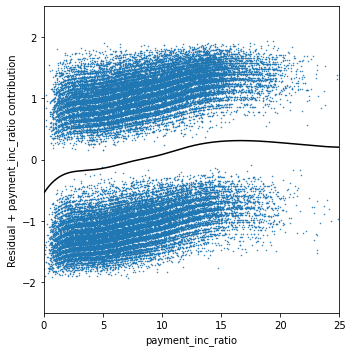

In [20]:
fig, ax = plt.subplots(figsize=(5, 5))
partialResidualPlot(results, loan_data, 'outcome', 'payment_inc_ratio', fig, ax)
ax.set_xlim(0, 25)
ax.set_ylim(-2.5, 2.5)

plt.tight_layout()
plt.show()

###### 주요개념
- 로지스틱 회귀는 출력이 이진변수라는 점만 빼면, 선형회귀와 매우 비슷하다.
- 선형모형과 비슷한 형태의 모델을 만들기 위해, 응답변수로 오즈비의 로그값을 사용하는 등의 몇 가지 변환이 필요하다.
- 반복 과정을 통해 선형모형을 피팅하고 나면, 로그 오즈비는 다시 확률값으로 변환된다.
- 로지스틱 회귀는 계산 속도가 빠르고 새로운 데이터에 대해서도 간단한 산술연산으로 빠르게 결과를 구할 수 있다는 장점 때문에 많이 사용된다.

## 5.4 분류 모델 평가하기

==========================================================================================================
###### 용어정리
- 정확도(accuracy): 정확히 분류된 비율
- 혼동행렬(confusion matrix): 분류에서 예측된 결과와 실제 결과에 대한 레코드의 개수를 표시한 테이블(이진형인 경우 2 x 2)
- 민감도(sensitivity): 1을 정확히 1로 분류한 비율(유의어: 재현율, recall)
- 특이도(specificity): 0을 정확히 0으로 분류한 비율
- 정밀도(precision): 1이라고 예측한 것들 중에 1이 맞는 경우의 비율
- ROC곡선(ROC curve): 민감도와 특이성을 표시한 그림
- 리프트(lift): 모델이 다른 확률 컷오프에 대해 (비교적 드문) 1을 얼마나 더 효과적으로 구분하는지 나타내는 측정 지표

==========================================================================================================

$$ accuracy = \frac {\sum{True Positive}+\sum{True Negative}} {n} $$

### 5.4.1 혼동행렬

In [21]:
# Confusion matrix
pred = logit_reg.predict(X)
pred_y = logit_reg.predict(X) == 'default'
true_y = y == 'default'
true_pos = true_y & pred_y
true_neg = ~true_y & ~pred_y
false_pos = ~true_y & pred_y
false_neg = true_y & ~pred_y

conf_mat = pd.DataFrame([[np.sum(true_pos), np.sum(false_neg)], [np.sum(false_pos), np.sum(true_neg)]],
                       index=['Y = default', 'Y = paid off'],
                       columns=['Yhat = default', 'Yhat = paid off'])
print(conf_mat)

'''
col: 예측값
row: 실제 결과
'''

              Yhat = default  Yhat = paid off
Y = default            14337             8334
Y = paid off            8149            14522


'\ncol: 예측값\nrow: 실제 결과\n'

In [22]:
from IPython.display import Image

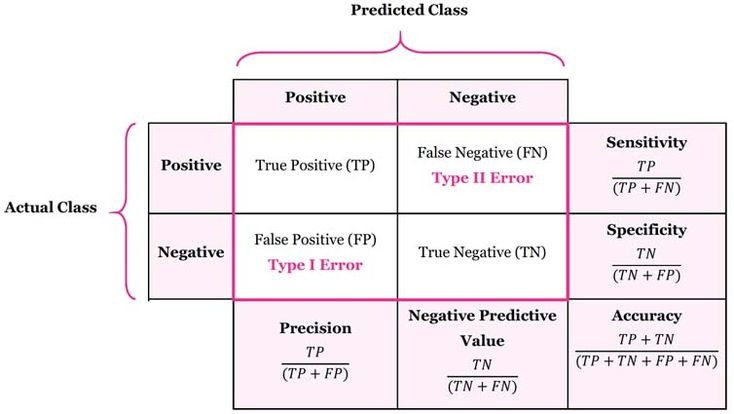

In [23]:
Image('C:/jupyter/[STUDY]statistics for ds/Basic_statistic/JawonMin/confusion_matrix.jpg')

### 5.4.2 회귀클래스 문제
 - 분류해야 할 클래스 간 불균형이 존재하는 사례. 즉, 한 클래수의 경우의 수가 다른 클래스보다 훨씬 많은 경우
 - 이 경우 <b>정확도</b>가 높은 모델이더라도 활용성이 떨어질 수 있다.

### 5.4.3 정밀도, 재현율, 특이도
 - 정밀도: 예측된 양성 결과의 정확도
 - 재현율(recall, 민감도): 양성 결과를 예측하는 모델 능력 평가
 - 특이도: 음성 결과를 정확히 예측하는 능력

$$ 정밀도 = \frac {\sum{참 양성(TP)}} {\sum{참 양성(TP)} + \sum{거짓 양성(FP)}} $$

$$ 재현율 = \frac {\sum{참 양성(TP)}} {\sum{참 양성(TP)} + \sum{거짓 음성(FN)}} $$ 

$$ 특이도 = \frac {\sum{참 음성(TN)}} {\sum{참 음성(TN)} + \sum{거짓 양성(FP)}} $$ 

In [24]:
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support

In [25]:
conf_mat = confusion_matrix(y, logit_reg.predict(X))
print('Precision', conf_mat[0, 0] / sum(conf_mat[:, 0]))
print('Recall', conf_mat[0, 0] / sum(conf_mat[0, :]))
print('Specificity', conf_mat[1, 1] / sum(conf_mat[1, :]))

precision_recall_fscore_support(y, logit_reg.predict(X), 
                                labels=['default', 'paid off'])

Precision 0.6375967268522637
Recall 0.6323938070662961
Specificity 0.640554011733051


(array([0.63759673, 0.63536927]),
 array([0.63239381, 0.64055401]),
 array([0.63498461, 0.63795111]),
 array([22671, 22671], dtype=int64))

### 5.4.4 ROC 곡선
 - 재현율과 특이도는 트레이드 오프 관계
 - 이상적인 분류기랑 0을 1이라고 잘못 분류하지 않으면서 동시에 1을 정말 잘 분류하는 분류기
 
###### <b>ROC곡선(receiver operating characteristic)</b>
 - x축의 특이도에 대한 y축의 재현율 표시
 - y축에 재현율을 표시하면서, x축에는 다음과 같은 두 가지 형태로 표시할 수 있다.
  - x축 왼쪽에 1부터 오른쪽아 0까지 특이도 표시
  - x축 왼쪽에 0부터 오른쪽에 1까지 1-특이도 표시
 - ROC곡선 계산 과정
  - 1. 1로 예측할 확률에 따라 가장 1이 되기 쉬운 것부터 1이 되기 어려운 순으로 레코드 정렬
  - 2. 정렬된 순서대로 점증적으로 특이도와 재현율 계산

In [26]:
from sklearn.metrics import roc_curve, accuracy_score, roc_auc_score

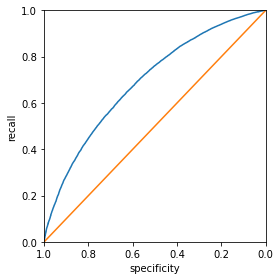

'\n - 노란선: 랜덤으로 예측했을 때의 결과\n - 극단적으로 효과적인 분류기: ROC 곡선이 왼쪽 상단에 가까운 형태를 보일 것.\n'

In [27]:
# [그림 5-6] 대출 데이터에 대한 ROC 곡선
fpr, tpr, thresholds = roc_curve(y, logit_reg.predict_proba(X)[:, 0], 
                                 pos_label='default')
roc_df = pd.DataFrame({'recall': tpr, 'specificity': 1 - fpr})

ax = roc_df.plot(x='specificity', y='recall', figsize=(4, 4), legend=False)
ax.set_ylim(0, 1)
ax.set_xlim(1, 0)
ax.plot((1, 0), (0, 1))
ax.set_xlabel('specificity')
ax.set_ylabel('recall')

plt.tight_layout()
plt.show()

'''
 - 노란선: 랜덤으로 예측했을 때의 결과
 - 극단적으로 효과적인 분류기: ROC 곡선이 왼쪽 상단에 가까운 형태를 보일 것.
'''

### 5.4.5 AUC
 - <b>AUC(area underneath the curve)</b>: ROC곡선의 아래쪽 면적을 의미하며, AUC값이 높을수록 더 좋은 분류기를 의미

In [28]:
print(np.sum(roc_df.recall[:-1] * np.diff(1 - roc_df.specificity)))
print(roc_auc_score([1 if yi == 'default' else 0 for yi in y], logit_reg.predict_proba(X)[:, 0]))


0.6917107135725116
0.6917107913974233


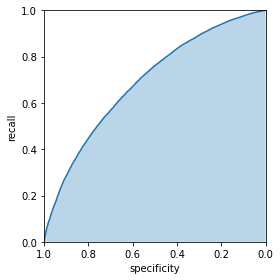

In [29]:
fpr, tpr, thresholds = roc_curve(y, logit_reg.predict_proba(X)[:,0], 
                                 pos_label='default')
roc_df = pd.DataFrame({'recall': tpr, 'specificity': 1 - fpr})

ax = roc_df.plot(x='specificity', y='recall', figsize=(4, 4), legend=False)
ax.set_ylim(0, 1)
ax.set_xlim(1, 0)
# ax.plot((1, 0), (0, 1))
ax.set_xlabel('specificity')
ax.set_ylabel('recall')
ax.fill_between(roc_df.specificity, 0, roc_df.recall, alpha=0.3)


plt.tight_layout()
plt.show()

###### CAUTION_ 거짓 양성 비율에 대한 혼동
거짓 양성/음성 비율은 종종 특이도나 민감도와 혼동되어 설명된다. 때로 거짓 양성비율은 검사 결과가 양성으로 잘못 나온 음성 데이터의 비율로 정의되기도 한다. 예를들어 네트워크 침입 탐지 등에서 실제 음성인 신호가 양성으로 탐지된 신호의 비율을 나타내는 데 사용된다.

### 5.4.6 리프트
 - 누적 이득 차트(cumulative gains chart): y축에 재현율, x축에 총 레코드 수
 - 리프트 곡선(lift curve): 임의 선택을 의미하는 대각선에 대한 누적 이들의 비율
 - 십분위 이득 차트(decline gains chart)
 
###### CAUTION_ 업리프트
업리프트(uplift)
- A/B검정을 수행하고, 처리 A나 B 가운데 하나를 예측변수로 사용하는 예측 모델에서 사용
- 처리 A와 처리 B 사이의 개별적인 한 케이스에 대해 예측된 결과의 향상을 의미

###### 주요개념
 - 정확도(예측한 분류 결과가 몇 퍼센트 정확한지)는 모델을 평가하는 가장 기본적인 단계이다.
 - 다른 평가 지표들(재현율, 특이도, 정밀도)은 좀 더 세부적인 성능 특성들을 나타낸다.(예를들면 재현율은 모델이 1을 얼마나 정확히 분류하는지를 나타낸다.)
 - AUC(ROC 곡선 아래 면적)는 모델의 1과 0을 구분하는 능력을 보여주기 위해 가장 보편적으로 사용되는 지표이다.
 - 이와 비슷하게, 리프트는 모델이 1을 얼마나 효과적으로 분류해내는지를 측정한다. 가장 1로 분류될 가능성이 높은 것부터 매 십분위마다 이를 계산한다.

## 5.5 불균형 데이터 다루기

==========================================================================================================
###### 용어정리
- 과소표본(undersample): 분류 모델에서 개수가 많은 클래스 데이터 중 일부 소수만을 사용하는 것(유의어: 다운샘플)
- 과잉표본(oversample): 분류 모델에서 회귀 클래스 데이터를 중복하여, 필요하면 부트스트랩해서 사용하는 것(유의어: 업샘플)
- 상향 가중치(up weight) 혹은 하양 가중치(down weight): 모델에서 희귀(혹은 다수) 클래스에 높은(혹은 낮은) 가중치를 주는 것
- 데이터 생성(data generation): 부트스트랩과 비슷하게 다시 샘플링한 레코드를 빼고 원래 원본과 살짝 다르게 데이터를 생성하는 것
- z 점수(z-score): 표준화 결과
- k: 최근접 이웃 알고리즘에서 이웃들의 개수


==========================================================================================================

### 5.5.1 과소표본추출
- 과소표본추출의 기본 아이디어: 다수의 클래스에 속한 데이터들 중 중복된 레코드가 많을 것이라는 사실에서 출발
- 작지만 더 균형 잡힌 데이터는 모델 성능에 좋은 영향을 주고, 데이터를 준비하는 과정이나 모델을 검증하는 과정이 좀 더 수월해진다.

In [30]:
full_train_set = pd.read_csv('C:/data/stats_for_ds/full_train_set.csv') ;full_train_set

,status,loan_amnt,term,annual_inc,dti,payment_inc_ratio,revol_bal,revol_util,purpose,home_ownership,delinq_2yrs_zero,pub_rec_zero,open_acc,grade,outcome,emp_length,purpose_,home_,emp_len_
0,Fully Paid,5000,36 months,24000,27.65,8.14350,13648.0,83.7,credit_card,RENT,1,1,3,5.4,paid off,11,credit_card,RENT,> 1 Year
1,Charged Off,2500,60 months,30000,1.00,2.39320,1687.0,9.4,car,RENT,1,1,3,4.8,default,1,major_purchase,RENT,> 1 Year
2,Fully Paid,2400,36 months,12252,8.72,8.25955,2956.0,98.5,small_business,RENT,1,1,2,5.0,paid off,11,small_business,RENT,> 1 Year
3,Fully Paid,10000,36 months,49200,20.00,8.27585,5598.0,21.0,other,RENT,1,1,10,4.2,paid off,11,other,RENT,> 1 Year
4,Fully Paid,5000,36 months,36000,11.20,5.21533,7963.0,28.3,wedding,RENT,1,1,9,6.8,paid off,4,other,RENT,> 1 Year
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119982,Fully Paid,7000,36 months,46200,30.05,6.11325,6835.0,43.0,debt_consolidation,MORTGAGE,1,1,12,5.8,paid off,11,debt_consolidation,MORTGAGE,> 1 Year
119983,Fully Paid,21000,60 months,91800,8.04,6.82092,12187.0,23.9,medical,RENT,1,1,14,3.2,paid off,3,medical,RENT,> 1 Year
119984,Fully Paid,28775,60 months,60000,13.72,15.40780,16542.0,78.4,home_improvement,MORTGAGE,1,0,14,2.2,paid off,11,home_improvement,MORTGAGE,> 1 Year
119985,Fully Paid,6000,36 months,57500,23.61,4.25113,5188.0,31.6,debt_consolidation,RENT,0,1,12,6.0,paid off,4,debt_consolidation,RENT,> 1 Year


In [31]:
print('percentage of loans in default: ', 
print(      100 * np.mean(full_train_set.outcome == 'default')))

18.894546909248504
percentage of loans in default:  None


In [32]:
# 모델 학습에 전체 데이터를 사용하는 경우
predictors = ['payment_inc_ratio', 'purpose_', 'home_', 'emp_len_', 
              'dti', 'revol_bal', 'revol_util']
outcome = 'outcome'
X = pd.get_dummies(full_train_set[predictors], prefix='', prefix_sep='', 
                   drop_first=True)
y = full_train_set[outcome]

full_model = LogisticRegression(penalty='l2', C=1e42, solver='liblinear')
full_model.fit(X, y)
print('percentage of loans predicted to default: ', 
print(      100 * np.mean(full_model.predict(X) == 'default')))


0.0
percentage of loans predicted to default:  None


### 5.5.2 과잉표본추출과 상향/하향 가중치
 - 과소클래스의 단점: 버려진 일부 데이터를 활용하지 못한다는 점. 버려진 데이터에 유용한 데이터가 있을 수 있음
 - 과잉표본추출: 복원추출 방식(부트스트랩)으로 희귀 클래스의 데이터를 업샘플링하는 것. 데이터에 가중치를 적용하는 방식으로 이와 비슷한 효과를 얻을 수 있음

In [33]:
default_wt = 1 / np.mean(full_train_set.outcome == 'default')
wt = [default_wt if outcome == 'default' else 1 for outcome in full_train_set.outcome]

full_model = LogisticRegression(penalty="l2", C=1e42, solver='liblinear')
full_model.fit(X, y, wt)
print('percentage of loans predicted to default (weighting): ', 
print(      100 * np.mean(full_model.predict(X) == 'default')))

61.20246360022335
percentage of loans predicted to default (weighting):  None


### 5.5.3 데이터 생성
##### SMOTE 알고리즘 (합성 소수 과잉표본 기법, synthetic minority oversampling technique)
 - 업샘플링된 레코드와 비슷한 레코드를 찾고, 원래 레코드와 이웃 레코드의 랜덤 가중평균으로 새로운 합성 레코드를 만듦
 - 여기에 대해 각각의 예측변수에 대해 개별적으로 가중치 생성
 - 새로 합성된 업샘플 레코드의 개수는 데이터의 균형을 맞추기 위해 필요한 업샘플링 비율에 따라 달라짐

### 5.5.4 비용 기반 분류
 - 때론 실무에서 분류 규칙을 정하는 데 정확도나 AUC만으로 충분하지 않을 수 있다.
 - 목적에 맞게 분류 규칙을 설정해야 함

### 5.5.5 예측 결과 분석
 - AUC와 같은 단일 성능 지표로는 모델 적합성을 여러 측면에서 보기 어려울 수 있다.


###### 주요개념
- 데이터의 심각한 불균형(즉, 관심 있는 결과의 데이터가 희박할 때)은 분류 알고리즘에서 문제가 될 수 있다.
- 불균형 데이터를 다루는 한 가지 방법은 다수의 데이터를 다운샘플링하거나 희귀한 데이터를 업샘플링해서 학습 데이터의 균형을 맞추는 것이다.
- 갖고 있는 1의 데이터를 모두 사용해도 그 개수가 너무 적을 때는, 희귀한 데이터에 대해 부트스트랩 방식을 사용하거나 기존의 데이터와 유사한 합성 데이터를 만들기 위해 SMOTE를 사용한다.
- 데이터에 불균형이 존재할 경우 보통은 어느 한쪽(1의 클래스)을 정확히 분류하는 것에 더 높은 점수를 주게 되어 있고, 이러한 가치 비율이 평가 지표에 반영되어야 한다.